In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


# 데이터 불러오기

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


# 학습 데이터에서 라벨 제거

In [4]:
# 우리 target (price) 는 y에 저장 후 학습 데이터에서제거
y = data['price']
del data['price']
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# 학습 데이터와 테스트 데이터 합치기
#### 모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 concat으로 합쳐보자

In [5]:
# 물론, 모델 학습을 진행할 때에는 다시 분리해야하니 데이터를 합치기 전에 train_len에 학습데이터의 개수를 저장하고
# 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
train_len = len(data)
data = pd.concat((data, sub), axis=0)
len(data)

21503

In [ ]:
data.head()

# 전처리

<AxesSubplot:>

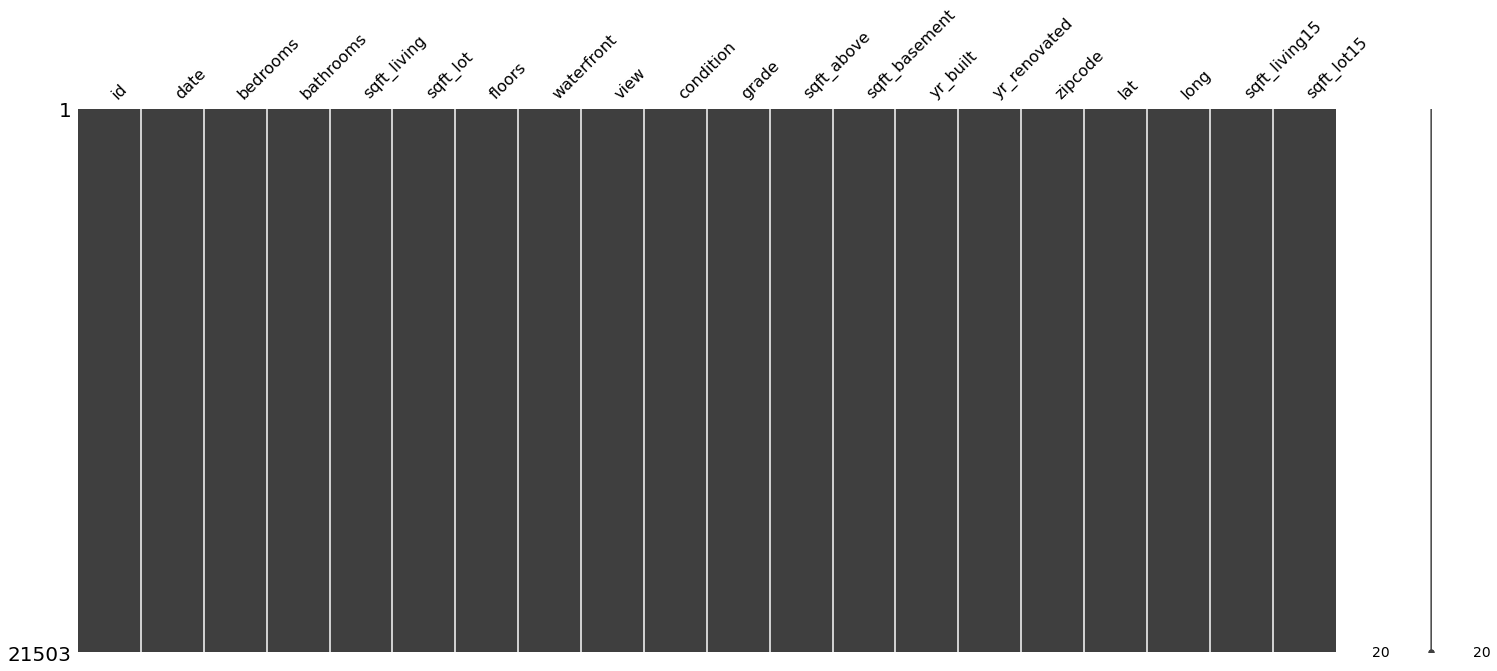

In [7]:
#빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업
# 결측치, 즉 빈 데이터가 있는지 위에 설치했던 missingno 라이브러리를 사용
# missingno라이브러리의 matrix함수를 사용하면 데이터의 결측 상태를 시각화를 통해 살펼볼 수 있음
msno.matrix(data)

In [16]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# date컬럼 필요한 부분만 자르기

In [17]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 전체 데이터들의 분포를 확인
#### sns.kdeplot() -> 이산데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 해주는 시각화 함수이다.

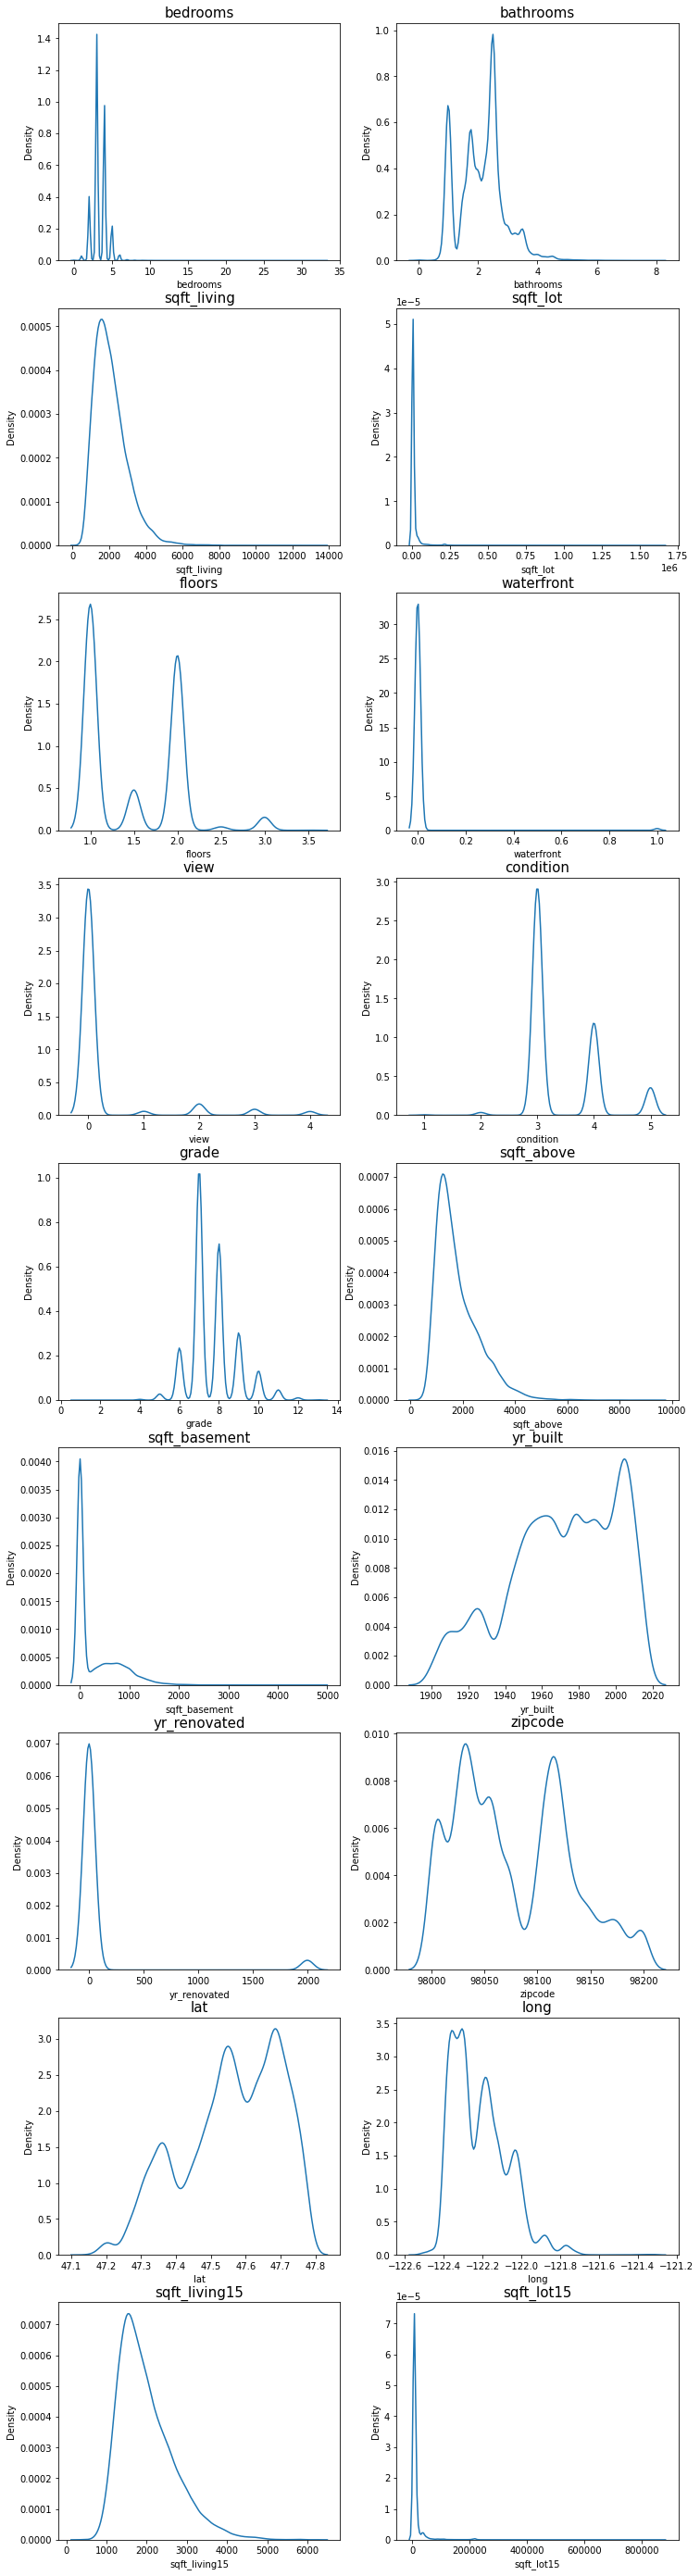

In [23]:
fig, ax = plt.subplots(9, 2, figsize=(12,50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [24]:
#위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우쳤네?
# 이렇게 한 쪽으로 치우는 분포의 경우는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다.
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for i in skew_columns:
    data[i] = np.log1p(data[i].values)

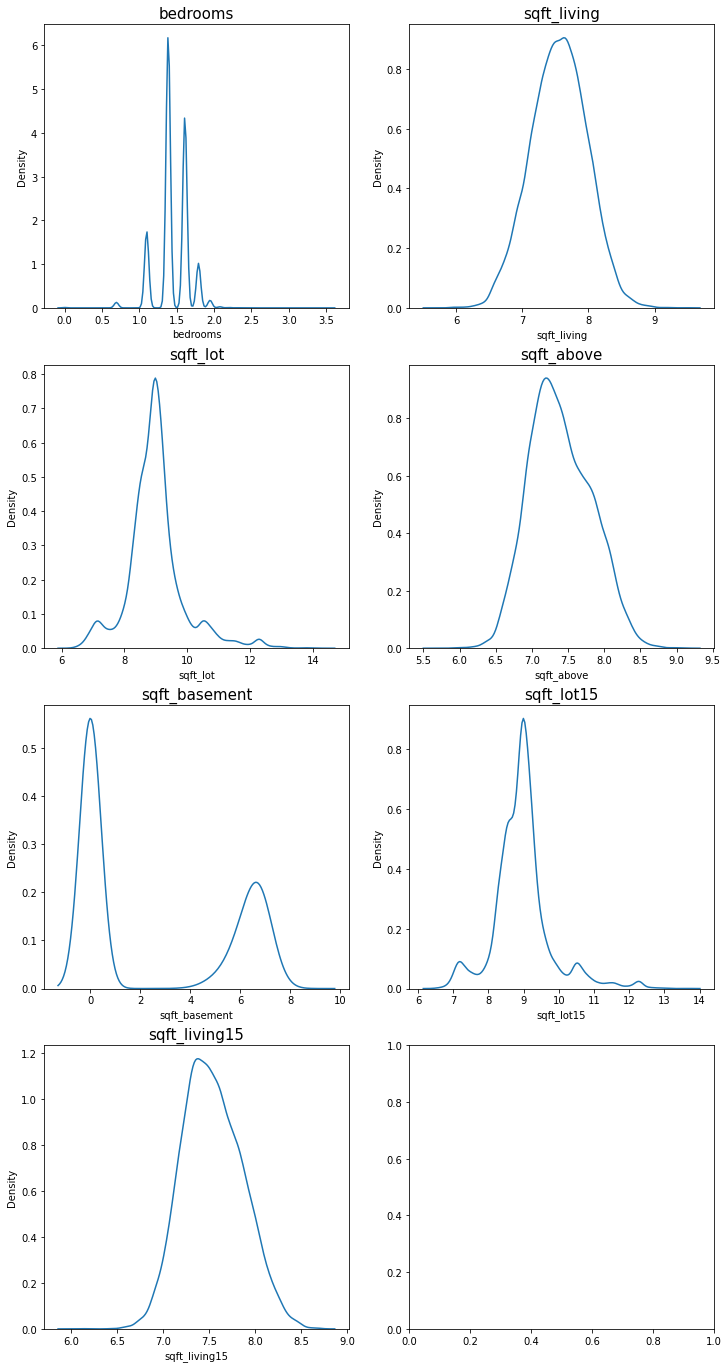

In [26]:
#변환 후 다시 확인
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

# 로그 변환
## np.log1p()함수는 너무 그래프가 한쪽으로 크게 치우쳐져있으면 좀 가운데쪽으로 펴준다.
### np.expm1()함수는 log1p()함수랑 반대임

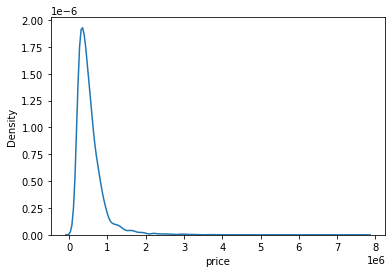

In [27]:
# price의 분포를 로그 변환했을 때 결과를 봐보자
# 원래 price의 분포
sns.kdeplot(y)
plt.show()

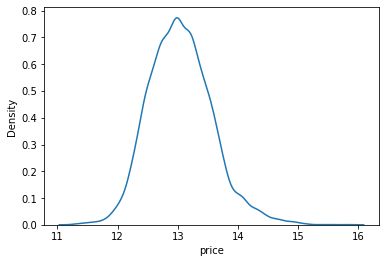

In [28]:
# log변환 후 price의 분포
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

# 로그 변환이 필요한 데이터에 대해 처리를 했으니 데이터를 다시 나누자
#### 위에 저장해둔 train_len를 인덱스로 활용해서 :train_len까지는 학습데이터, 즉 X에 저장하고,
#### train_len:부터는 테스트데이터, 즉 sub에 저장

In [29]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 모델링
#### 블렌딩이란? : 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법
#### -> 블렌딩은 앙상블 기법이라고 하기도 함.
# 앙상블 기법 중 가장 기본적인 것
#### 보팅 : 여러 모델이 분류해 낸 결과들을 다수결로 투표 / 분류
#### 에버리징 : 각 예측값을 평균 / 회귀

# Average Blending 
### -> AveragingBlending()함수 -> 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어줌
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용

In [36]:
# Average Blending -> 여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들어보자
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

# Cross Validation
### -> 교차 검증을 통해 모델의 성능을 간단히 평가해보자
###### cross_val_score()함수는 회귀모델을 전달할 경우 R(2승) 점수를 반환 / R값은 1에 가까울수록 모델이 잘 학습된거를 나타냄

In [39]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [40]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [49]:
# Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용한다. 
# AveragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 
# predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [50]:
# 예측값
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

# 제출해야 하는 csv 파일의 샘플이 바로 data 폴더에 있는 sample_submission.csv 이다.
##### 다음 코드로 확인해보자

In [63]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [64]:
# id와 price가 있다. 우리도 이에 맞게 id와 price로 구성된 프레임을 만들어주자
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


# submission.csv 파일로 저장

In [65]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝
#### 나는 아직 모델을 하나도 건들지 않았다.
#### 이번엔 직접 다양한 하이퍼 파라미터를 튜닝해보면서 모델의 성능을 끌어올려 볼 거다.

# 위에는 Baseline(샘플)로 해봤으니 이번엔 주도적으로 다시 다뤄본다.

### 데이터 가져오기

In [66]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### date가 눈에 거슬린다.. 전처리를 먼저 해보자
##### -> Baseline과 달리 이번엔 int, 즉 정수형 데이터로 처리해보자

In [67]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 타겟 데이터에 해당하는 price컬럼 처리
##### y변수에 price를 넣고 프레임에서 price삭제

In [68]:
y = train['price']
del train['price']
train.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [69]:
# id컬럼 삭제 -> 솔직히 얜 왜하는지 모르겠음
del train['id']
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# test데이터에도 같은 작업을 해야한다. 
### -> train컬럼과 test컬럼의 개수가 같아야함.

In [72]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [73]:
y  # target data

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

# Seaborn의 'kdeplot'을 활용해 'y'의 분포를 확인해보자

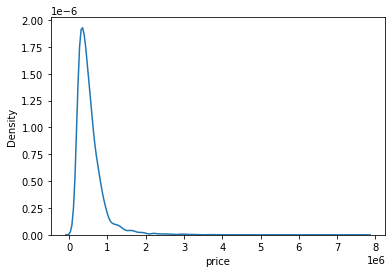

In [74]:
# log변환 전
sns.kdeplot(y)
plt.show()

In [75]:
# 위에 그래프가 너무 왼쪽으로 치우쳐있으니 로그 np.log1p()함수로 변환.
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

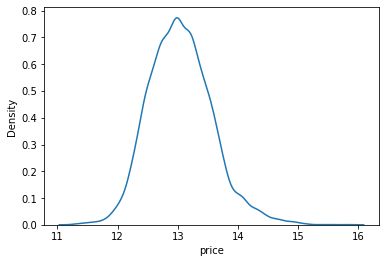

In [76]:
# log변환 후
sns.kdeplot(y)
plt.show()

In [77]:
#정보확인
train.info()  # 모두 실수 또는 정수이니 문제없이 모델 학습 가능

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 본격적으로 모델 튜닝을 해보자

In [80]:
#먼저 필요한 라이브러리를 먼저 가져오자
# 1. 데이터 분리
# 2. RMSE계산
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [82]:
# 위에서 y_test, y_pred를 log로 변환했으니 다시 변환해야하는것을 잊으면 안됨!
# expm1()로 바꾸고 RMSE계산하기 하는 함수를 만들자
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [83]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [84]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [85]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [86]:
# 위 과정을 함수로 만들어보자
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


# 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

### RMSE결괏값을 나타내주는 함수가 준비되어있으니 다양한 하이퍼 파라미터로 실험하는 일만남음
### 실험은 sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용

In [87]:
from sklearn.model_selection import GridSearchCV

# 우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있다.
## 그리드 탐색 -> 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색한다. (특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리함)
## 랜덤 탐색 -> 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법

### 그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면,          랜덤 탐색은 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려있다.  / 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없다. 

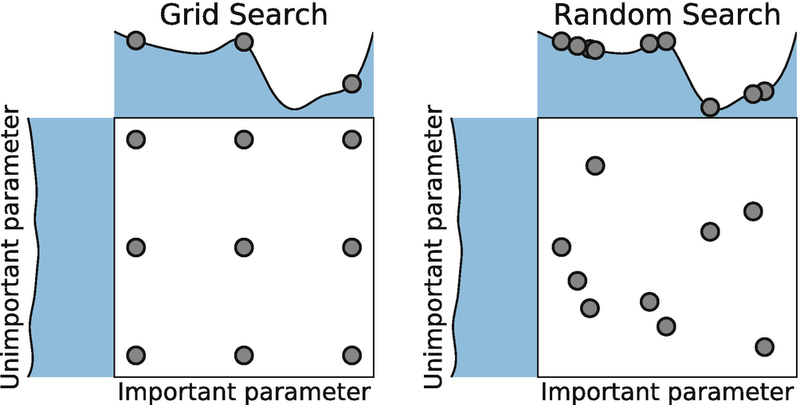

In [88]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1, 10],
}

In [89]:
#모델 준비. -모델은 LightGBM(lgbm)를 사용
model = LGBMRegressor(random_state=random_state)

In [90]:
# GridSearchCV를 이용해서 grid_model 모델을 초기화하고, 
# train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료된다.
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [91]:
# 실험에 대한 결과는 여기에 저장된다.
grid_model.cv_results_

{'mean_fit_time': array([0.92935538, 1.28024054, 2.22388616, 2.56111474]),
 'std_fit_time': array([0.03588738, 0.04848613, 0.07853352, 0.34552348]),
 'mean_score_time': array([0.07071562, 0.08733854, 0.16232805, 0.16041508]),
 'std_score_time': array([0.01460957, 0.01716704, 0.01029159, 0.06970402]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [92]:
# 정보가 너무 많다... 우리가 관심 있는 정보는 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이니 그것만 빼오자
# 파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장되어있다.
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [93]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [94]:
# 이 둘의 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아보자
import pandas as pd
a = pd.DataFrame(params)
a['score'] = score
a

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [95]:
# neg_mean_squared_error 이녀석을 사용해서 값이 음수가 나온다 
# 아래와 같은 간단한 변환 함수로 RMSE점수를 볼 수 있도록 해보자
a['RMSE'] = np.sqrt(-1 * a['score'])
a

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [96]:
results = a.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [97]:
# 순서 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [98]:
# 지금까지 그리드 탐색을 수행하고 그 결과를 깔끔하게 확인했다. 이 과정을 하나의 함수로 만들어서 앞으로는 간결한 코드로 진행하자
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [99]:
# 위에 만들어놓은 my_GridSearch()함수로 그리드 탐색을 해보자
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [100]:
# 가장 좋은 조합은 max_depth=10, n_estimators=100이다.
# 해당 모델로 학습을 해서 예측값인 submission.csv파일을 만들어서 제출해보자
# 먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성하자
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [101]:
# expm1()로 다시 원래 스케일로 돌리는 것을 까먹으면 안됨!
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [102]:
# 위에서 했던대로 sample_submission.csv 파일을 가져와보자
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [103]:
# 위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성된다.
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [104]:
# 위의 데이터를 csv파일로 저장하자
# 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [105]:
# 위의 과정들도 하나의 함수로 정리해두면 사용하기 편리하겠다.
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [106]:
# 이 함수를 사용한다면 다음 한 줄로 모델을 학습시킨 후 예측 결과를 저장할 수 있다.
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.6s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.4s
[CV] END ....................

In [ ]:
# 순서가 결측치까지하고, 모델링 -> 그리드탐색 -> 성능평가

# 밑에 더 있습니다!

# 11만점 아래입니다!

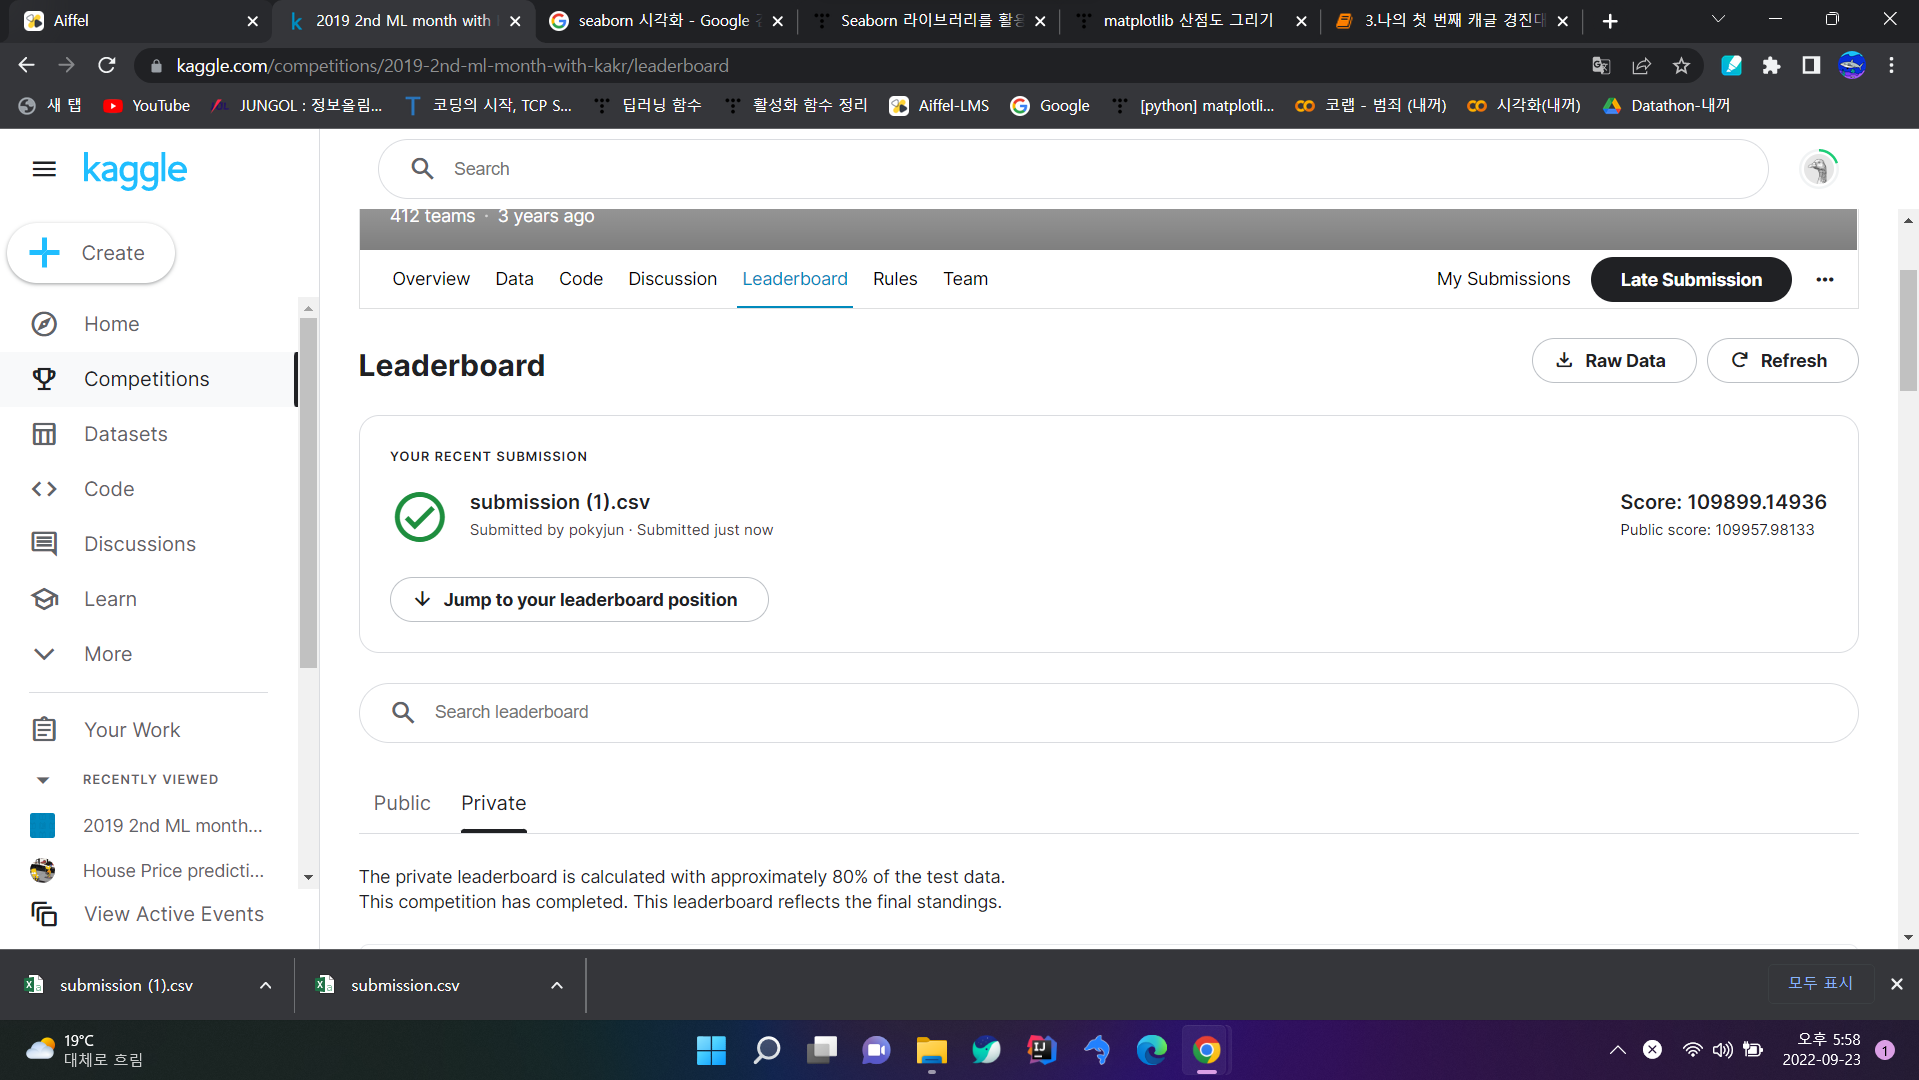

In [ ]:
random_state=2022
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
gboost = GradientBoostingRegressor(random_state=random_state, max_depth=10 ,n_estimators=10000)
xgboost = XGBRegressor(random_state=random_state,max_depth=10 ,n_estimators=10000)
lightgbm = LGBMRegressor(random_state=random_state,learning_rate = 0.007, max_depth=10 ,n_estimators=10000)
rdforest = RandomForestRegressor(random_state=random_state,max_depth=10 ,n_estimators=10000)

models = [lightgbm]

# 4가지 모델을 돌리다가 너무 오래걸려서 고민하던중 lightgbm이 성능이 가장 좋다고 얘기를 들어서 저거 하나만 파고 
# lerning_rate, max_depth, n_estiators는 그냥 노가다로 막 돌아가면서 지정해봤습니다

In [ ]:
# Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용한다. 
# AveragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 
# predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
# 예측값
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
sub